# Principal Component Analysis - PCA

Notebook de experimentação e estudo sobre PCA

## 0.0. Imports

In [99]:
import pandas as pd
import numpy as np

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import decomposition as d
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

## 0.1. Carregando dados

In [100]:
df_raw = pd.read_csv('../../dados/vehicle.csv')

# Seleciona apenas Carros e ônibus
df1 = df_raw[df_raw['class'].isin(['car', 'bus'])]

In [101]:
# Valida Nulos
df1.isna().sum()

df1 = df1.dropna()

In [102]:
x = df1.drop('class', axis=1)
y = df1['class']

x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.1, random_state=42)

# 1.0. Redes Neurais sem PCA

In [103]:
# HOLD OUT
train_acc_list = []
val_acc_list = []

for i in range(0, 5):
    # split treino e validação
    x_train, x_val, y_train, y_val = ms.train_test_split(x, y, test_size=0.2)

    # y para NN
    ohe = pp.OneHotEncoder()
    y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
    y_val = ohe.transform(y_val.values.reshape(-1, 1)).toarray()


    # MLP: Neural Network 
    ## Definição modelo
    model = Sequential()
    model.add(Dense(2, input_dim=x_train.shape[1], activation='relu')) # 2 neurons on Hidden Layer + Input Layer
    model.add(Dense(2, activation='softmax'))

    ## model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    ### model fit (treino)
    es = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[es], verbose=0)

    ## model evaluate
    _, train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, val_acc = model.evaluate(x_val, y_val, verbose=0)

    #print('Train ACC:{} - Val ACC:{}'.format(train_acc, val_acc))
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

In [104]:
print('Train ACC AVG: {} +/- {}'.format(np.mean(train_acc_list), np.std(train_acc_list)))
print('Val ACC AVG: {} +/- {}'.format(np.mean(val_acc_list), np.std(val_acc_list))) 

Train ACC AVG: 0.6963562726974487 +/- 0.06252406963210726
Val ACC AVG: 0.7096774101257324 +/- 0.04945068572441185


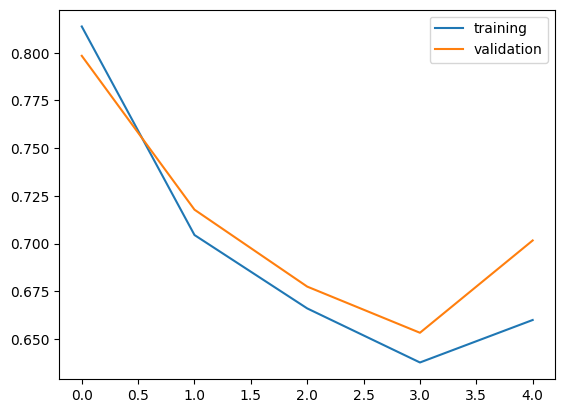

In [105]:
plt.plot(train_acc_list, label='training')
plt.plot(val_acc_list, label='validation')
plt.legend()

Validando acurrácia com dados de teste.

In [106]:
y_test_nn = ohe.transform(y_test.values.reshape(-1, 1) ).toarray()
_, test_acc = model.evaluate(x_test, y_test_nn, verbose=0)

print('Test ACC:{}'.format(test_acc))

Test ACC:0.6774193644523621


# 2.0. Redes Neurais com PCA

In [152]:
# split treino e validação
x_train, x_val, y_train, y_val = ms.train_test_split(x, y, test_size=0.2, random_state=42)

**Normalização**

In [153]:
# Normalização e rescala
ss = pp.StandardScaler()
x_train_scaler = ss.fit_transform(x_train)
x_val_scaler = ss.transform(x_val)

In [154]:
# Mudando dados para novo espaço
pca = d.PCA().fit(x_train_scaler)
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)

pca = d.PCA(k).fit(x_train_scaler)

x_train = pca.transform(x_train_scaler)
x_val = pca.transform(x_val_scaler)

x_train.shape

(494, 6)

Reduziu de 18 features para 6, que representam 95% da variabilidade dos dados

In [155]:
# y para NN
ohe = pp.OneHotEncoder()
y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_val = ohe.transform(y_val.values.reshape(-1, 1)).toarray()


# MLP: Neural Network 
## Definição modelo
model = Sequential()
model.add(Dense(2, input_dim=x_train.shape[1], activation='relu')) # 2 neurons on Hidden Layer + Input Layer
model.add(Dense(2, activation='softmax'))

## model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### model fit (treino)
es = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[es], verbose=0)

## model evaluate
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, val_acc = model.evaluate(x_val, y_val, verbose=0)

print('Train ACC:{} - Val ACC:{}'.format(train_acc, val_acc))

Train ACC:0.840080976486206 - Val ACC:0.8387096524238586


In [156]:
# 
x_test_nn = pca.transform(ss.transform(x_test))
y_test_nn = ohe.transform(y_test.values.reshape(-1, 1) ).toarray()
_, test_acc = model.evaluate(x_test_nn, y_test_nn, verbose=0)

print('Test ACC:{}'.format(test_acc))

Test ACC:0.8225806355476379


## Como determinar o número de PCAs?

In [157]:
# Definindo numeros de autovetores e autovalores
pca = d.PCA().fit(x_train_scaler)

# autovalores
pca.explained_variance_ratio_

array([0.53787237, 0.1758229 , 0.08700076, 0.06084684, 0.05336559,
       0.02996527, 0.02171917, 0.01227659, 0.00734969, 0.00542576,
       0.00250105, 0.00184864, 0.00137738, 0.00100088, 0.00077007,
       0.00050955, 0.0003313 , 0.00001618])

In [158]:
cumsum_autovalores = np.cumsum(pca.explained_variance_ratio_)
cumsum_autovalores

array([0.53787237, 0.71369527, 0.80069603, 0.86154287, 0.91490845,
       0.94487373, 0.9665929 , 0.97886949, 0.98621918, 0.99164494,
       0.99414599, 0.99599463, 0.99737201, 0.9983729 , 0.99914297,
       0.99965252, 0.99998382, 1.        ])

In [159]:
k = np.argmax(cumsum_autovalores > 0.95)
k

6

Entendendo a variabilidade dos dados e quantos autovetores precisamos para ter uma boa explicabilidade dos dados, sem precisar usar todos.

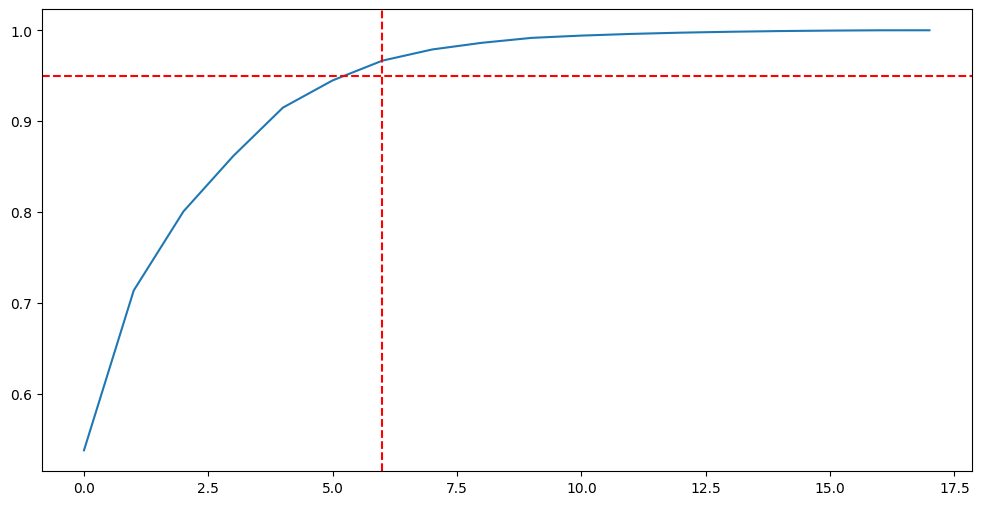

In [160]:
plt.figure(figsize=(12,6))
plt.plot(cumsum_autovalores)
plt.axvline(k, linestyle='--', color='red')
plt.axhline(0.95, linestyle='--', color='red')